# Series de tiempo cierre acciones - LSTM y PCA


Con la ayuda de Principal Component Analysis (PCA) se analizarán las características del dataset, con el fin de revisar su variabilidad y la posibiidad de reducir sus características. Luego, se crearán diferentes tipos de modelos de arquitectura LSTM, donde varia el número de neuronas de la capa LSTM y el lookback para realizar el mismo ejercicio de los anteriores notebooks: Entrenamiento de los modelos, selección del mejor modelo y predicciones con éste último.

## Contenido

#### 1. Importación de librerías y cargue del dataset
#### 2. PCA
#### 3. Definión funciones de creación de dataset y gráficos de los modelos
#### 4. LSTM

## 1. Importación de librerías y cargue del dataset

A continuación, se cargan las librerías necesarias para completar esta tarea:

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import decomposition
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.models import Sequential
%matplotlib inline

In [0]:
Se lee el archivo de excel que contiene la información del dataset y se convierte la columna fecha en el id de cada final.

In [0]:
!mkdir ./data
!mv Dataset.xls ./data

In [4]:
dataset = pd.read_excel('./data/Dataset.xls')
dataset.set_index('fecha',inplace=True)
dataset = dataset.drop(dataset.columns[[0]], axis=1)
dataset.head()

,Cantidad,Volumen,BCOLOMBIA,Precio Mayor,Precio Medio,Precio Menor,Variacion,Variacion Absoluta,COLCAP,BOGOTA,OCCIDENTE,POPULAR,BBVACOL,BVC,PROTECCION,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,Fourier3,Fourier6,Fourier9,Fourier100,ARIMA
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-02-14,486958,7207593760,14720,14860,14801.2637,14720,0.14,20,928.67,29340,20120,297,200,29.9,36600,14468.571429,14560.000000,14613.990768,14627.916145,13.925378,583.488601,15726.977202,13393.022798,14696.852167,14719,9.596894,(23077.7896372-2047.39795493j),(23674.5437646-650.00805727j),(23945.950803-130.487624855j),(14657.7161987-17.6998958368j),14720.0
2008-02-15,177200,2612417120,14800,14900,14742.7603,14600,0.54,80,929.63,29400,20120,297,200,29.7,36600,14540.000000,14569.523810,14630.874906,14655.079016,24.204110,575.509843,15720.543495,13418.504124,14765.617389,14799,9.602315,(23037.1586527-2046.75954045j),(23584.8975715-648.262236787j),(23821.3641891-129.870353806j),(14978.1025656-27.1178367253j),14800.0
2008-02-18,41671,619473620,14980,14980,14865.8208,14800,1.22,180,944.25,29360,20120,297,200,30.7,36600,14662.857143,14611.428571,14662.044720,14706.162364,44.117644,449.725062,15510.878696,13711.978447,14908.539130,14979,9.614404,(22996.5552587-2046.02572901j),(23495.2077147-646.395558862j),(23696.6789755-129.19860656j),(15256.4954598-35.1374565661j),14980.0
2008-02-20,153372,2285441560,15000,15100,14901.2959,14740,-1.06,-160,941.38,29200,20120,297,200,30.0,36600,14762.857143,14704.761905,14691.765372,14752.203625,60.438253,373.659006,15452.079916,13957.443893,14969.513043,14999,9.615739,(22915.4357998-2044.27205648j),(23315.7211407-642.301045191j),(23447.0773391-127.692833309j),(15646.3056008-45.4210457344j),15000.0
2008-02-21,535243,8086448540,15200,15200,15107.9949,15000,1.33,200,944.38,29120,20120,297,200,29.8,36600,14857.142857,14780.952381,14735.849445,14822.169663,86.320217,326.246597,15433.445575,14128.459187,15123.171014,15199,9.628985,(22874.9220125-2043.25227713j),(23225.9365058-640.073972798j),(23322.1932437-126.859438924j),(15745.9082169-47.1547456558j),15200.0


Los componentes de la transformada de Fourier se convierten al formato de número complejo, debido a que al leerlos del archivo quedan como texto.

In [0]:
dataset['Fourier3'] = np.asarray(dataset['Fourier3'].tolist()).astype('complex').real
dataset['Fourier6'] = np.asarray(dataset['Fourier6'].tolist()).astype('complex').real
dataset['Fourier9'] = np.asarray(dataset['Fourier9'].tolist()).astype('complex').real
dataset['Fourier100'] = np.asarray(dataset['Fourier100'].tolist()).astype('complex').real

## PCA

Se normalizan el dataset.

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(dataset)
data_scaled = scaler.transform(dataset)
data_scaled.shape

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(2738, 31)

Se trasnforman los datos con PCA, donde se observa que la dimensión del dataset transformado es igual a la original.

In [7]:
n_components = min(len(data_scaled), data_scaled.shape[1])
pca = decomposition.PCA(n_components=n_components)
pca.fit(data_scaled)
data_pca = pca.transform(data_scaled)
data_pca.shape

(2738, 31)

A continuación se revisa la varianza de los datos con PCA, encontrando  que con 6 componentes tenemos algo mas del 94% de varianza explicada.
 

In [8]:
expl_var = pca.explained_variance_ratio_
print(expl_var)
print('porcentaje varianza:',sum(expl_var[0:6]))

[7.53139121e-01 7.82956869e-02 5.38278493e-02 2.52394736e-02
 2.07532328e-02 1.69722329e-02 1.29602872e-02 1.01908574e-02
 8.31646415e-03 6.90189222e-03 5.04726965e-03 2.47615839e-03
 1.85579774e-03 1.31728648e-03 1.01879394e-03 4.94830156e-04
 4.21980538e-04 2.76929602e-04 2.13662178e-04 1.72155984e-04
 4.76635320e-05 2.37482027e-05 1.68691148e-05 1.03337317e-05
 6.98214224e-06 2.12403871e-06 3.16936600e-07 1.48530502e-31
 1.17306637e-32 5.00460557e-33 4.28176157e-33]
('porcentaje varianza:', 0.9482275967173559)


Se grafica el acumulado de varianza explicada.


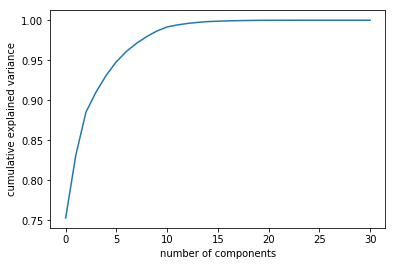

In [9]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

## 2. Definión funciones de creación de dataset y gráficos de los modelos

Función para construir el dataset con múltiples características para train y test de acuerdo al lookback, time_ahead y caractetística a predecir.

In [0]:
def create_dataset_nfeatures(dataset, n_steps_out=1, n_steps_in = 1, overlap = 1, index_feature_pred = None):
    dataX, dataY = [], []
    tem = n_steps_in + n_steps_out - overlap
    for i in range(int((len(dataset) - tem)/overlap)):
        startx = i*overlap
        endx = startx + n_steps_in
        starty = endx
        endy = endx + n_steps_out
        a = dataset[startx:endx, :]
        dataX.append(a)
        dataY.append(dataset[starty:endy,index_feature_pred])
    return np.array(dataX), np.array(dataY)

Función que grafica la pérdida mse de diferentes modelos.

In [0]:
def plot_metrics_model(mse, combinations, title):
    plt.figure(figsize=(20,8))
    plt.plot(mse, lw=4, alpha=.5, label="MSE models")
    plt.grid();
    plt.xlabel("Number of steps in")
    plt.ylabel("MSE")
    plt.title(title)    
    plt.xticks(np.arange(len(combinations)), combinations, rotation=90)
    plt.legend();
    plt.show()  

Función que grafica las predicciones de un modelo con la serie original.

In [0]:
def plot_predictions_model(x_lab1, Original_serie, x_lab2, trainPredict, x_lab3, testPredict, title):
    plt.plot(x_lab1,Original_serie, alpha=1, label='Original series');
    plt.plot(x_lab2,trainPredict,alpha=0.6, label='train prediction');
    plt.plot(x_lab3,testPredict, alpha=0.6, label='test prediction');
    plt.title(title);
    plt.legend();
    plt.show()  

Se crean los datos de train y test proveniendo del dataset transformado por PCA, el cual ya está normalizado. Sólo se toman las primeras 6 características, de acuerdo a la varianza representada en el análisis de PCA.

In [10]:
train_size = int(len(data_pca) * 0.67)
test_size = len(data_pca) - train_size
trainN, testN = data_pca[0:train_size,0:6], data_pca[train_size:len(data_pca),0:6]
trainN.shape, testN.shape

((1834, 6), (904, 6))

En la siguiente celda, se crean varios datasets de train y test donde para diferentes lookback. Se define time_ahead igual a 1 para predecir un solo movimiento y se selecciona la caractetística a predecir.

In [0]:
time_ahead=1

X_train=[]
y_train=[]
X_test=[]
y_test=[]
for i in range (10):
    X_trainTemp, y_trainTemp = create_dataset_nfeatures(trainN, time_ahead,i+1,index_feature_pred=2)
    X_testTemp, y_testTemp = create_dataset_nfeatures(testN, time_ahead,i+1,index_feature_pred=2)
    X_train.append(X_trainTemp),y_train.append(y_trainTemp),X_test.append(X_testTemp), y_test.append(y_testTemp)

In [15]:
len(X_train),X_train[0].shape,len(y_train),y_train[0].shape

(10, (1833, 1, 6), 10, (1833, 1))

Se definen las listas para crear diferentes tipos de modelos, donde se combinarán diferentes dimesiones de la capa LSTM y lookbacks.

In [0]:
ltsm_dim_set = [64,128,196,256]
look_back_set = [1,2,3,4,5,6,7,8,9,10]

## 3. LSTM

Función para crear, entrenar y calcular pérdida mse de modelos de arquitectura LTSM.

In [0]:
def LSTM_model(ltsm_dim, X_train, y_train, X_test, y_test, look_back):
    X_train=X_train[look_back-1]
    y_train=y_train[look_back-1]
    X_test=X_test[look_back-1]
    y_test=y_test[look_back-1]
    
    model = Sequential()    
    model.add(LSTM(ltsm_dim, input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse')
    
    print "Entrenado modelo LSTM con look_back de", look_back, "y neuronas", ltsm_dim
    model.fit(X_train, y_train.flatten(),epochs=50, verbose=1)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test,pred)
    return model, mse

Se crean los modelos LSTM con diferentes número de neuronas de la capa LSTM y lookback.

In [18]:
LSTM_models=[]
LSTM_mse=[]
LSTM_combinations = []
for ltsm_dim, look_back in itertools.product(ltsm_dim_set, look_back_set):
    model, mse = LSTM_model(ltsm_dim, X_train, y_train, X_test, y_test,look_back=look_back)
    LSTM_models.append(model), LSTM_mse.append(mse)
    LSTM_combinations.append('lstm '+str(ltsm_dim)+' - look_back '+str(look_back))

Instructions for updating:
Colocations handled automatically by placer.
Entrenado modelo LSTM con look_back de 1 y neuronas 64
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1833/1833 [==============================] - 3s 2ms/step - loss: 0.0462
Epoch 2/50
1833/1833 [==============================] - 0s 157us/step - loss: 0.0192
Epoch 3/50
1833/1833 [==============================] - 0s 157us/step - loss: 0.0063
Epoch 4/50
1833/1833 [==============================] - 0s 159us/step - loss: 0.0032
Epoch 5/50
1833/1833 [==============================] - 0s 163us/step - loss: 0.0020
Epoch 6/50
1833/1833 [==============================] - 0s 159us/step - loss: 0.0013
Epoch 7/50
1833/1833 [==============================] - 0s 158us/step - loss: 8.7626e-04
Epoch 8/50
1833/1833 [==============================] - 0s 161us/step - loss: 6.7612e-04
Epoch 9/50
1833/1833 [==============================] - 0s 160us/step - loss: 5.7212e-04
Epoch 10/50
1833/1833 [===========================

Se grafica la pérdida mse de los modelos LSTM.

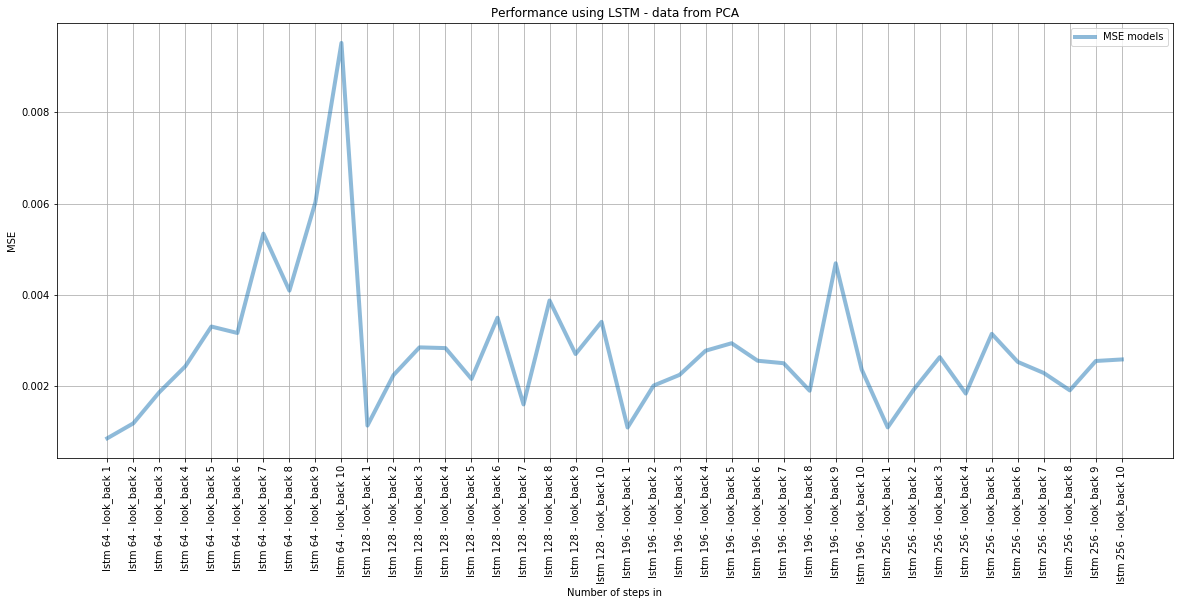

In [19]:
plot_metrics_model(LSTM_mse,LSTM_combinations, "Performance using LSTM - data from PCA")

Se muestra la pérdida mse de los modelos LSTM.

In [20]:
columns = ['model', 'mse']
df_models_lstm = pd.DataFrame(columns=columns)
df_models_lstm['model'] = LSTM_combinations
df_models_lstm['mse'] = LSTM_mse
df_models_lstm

,model,mse
0,lstm 64 - look_back 1,0.000863
1,lstm 64 - look_back 2,0.001190
2,lstm 64 - look_back 3,0.001872
3,lstm 64 - look_back 4,0.002440
4,lstm 64 - look_back 5,0.003310
5,lstm 64 - look_back 6,0.003169
6,lstm 64 - look_back 7,0.005345
7,lstm 64 - look_back 8,0.004096
8,lstm 64 - look_back 9,0.006034
9,lstm 64 - look_back 10,0.009521


Elegimos el modelo LSTM de menor pérdida mse.

In [21]:
index_model_min_mse = df_models_lstm[df_models_lstm.mse == df_models_lstm.mse.min()].index[0]
look_back = df_models_lstm.loc[index_model_min_mse,'model']
look_back = int(look_back[look_back.rfind(" ")+1:])
print index_model_min_mse, look_back
df_models_lstm[df_models_lstm.mse == df_models_lstm.mse.min()]

0 1


,model,mse
0,lstm 64 - look_back 1,0.000863


Realizamos las predicciones con el modelo LSTM seleccionado.

In [22]:
model_lstm = LSTM_models[index_model_min_mse]
model_lstm.summary()
trainPredict = model_lstm.predict(X_train[look_back-1])
testPredict = model_lstm.predict(X_test[look_back-1])
trainPredict.shape, testPredict.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18176     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________


((1833, 1), (903, 1))

In [23]:
Original_serie = scaler.fit_transform(data_pca[:,2].reshape(-1, 1))
Original_serie.shape

(2738, 1)

In [0]:
# data_pca_inversa = pca.inverse_transform(data_pca)
# Original_serie = scaler.fit_transform(data_pca_inversa[:,2].reshape(-1, 1))
# data_pca_inversa.shape, Original_serie.shape

In [27]:
x_lab1=[]
for i in range(Original_serie.shape[0]):
    x_lab1.append(i)
x_lab2=[]
for i in range(trainPredict.shape[0]):
    x_lab2.append(i)
x_lab3=[]
for i in range(trainPredict.shape[0]+9,Original_serie.shape[0]+7):
    x_lab3.append(i)
    
len(x_lab1), Original_serie.shape[0],len(x_lab2), trainPredict.shape[0],len(x_lab3), testPredict.shape[0]

(2738, 2738, 1833, 1833, 903, 903)

Se grafican las predicciones del modelo LSTM con los datos transformados de PCA.

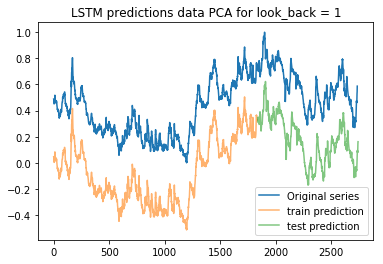

In [28]:
plot_predictions_model(x_lab1, 
                       Original_serie, 
                       x_lab2, 
                       trainPredict, 
                       x_lab3, 
                       testPredict, 
                       "LSTM predictions data PCA for look_back = "+ str(look_back))

Se exporta el modelo LSTM entrenado con el dataset transformado por PCA.

In [0]:
model_dir = './models/'
tf.gfile.MakeDirs(model_dir)
model_name = df_models_lstm.loc[index_model_min_mse,'model']
model_lstm.save(model_dir+model_name+"_PCA.model")